# Generate Training Data

In order to train the discriminative models, we need training data. To this end, we create synthetic training data via a simple simulation of kicks on goal. The algorithm works as follows:

- Sample a position (i.e. $x \in [0, 1]$ and $y \in [0, 2]$)
- Sample from one of the possible ranges `{wide-left`, `block-left`, `block-center`, `block-right`, `wide-right}`
- Sample from one the possible powers `{weak`, `strong}`
- Kick!
- Record each sample

### Stochastic Training Data Generator

In [750]:
import math
import random

from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])
State = namedtuple('State', ['x', 'y', 'dx', 'dy'])
World = namedtuple('World', ['width', 'height', 'nao_width', 'goal_width'])

def data_generator(world, num_samples=100, x_goal=2, y_goal=1, time_steps=10, decay=.8, zero_dy=False):
    """Yields successive States of ball kicks
    
    Parameters
    ----------
    world : World
    The dimensions of the world
    
    x_goal : float
    The x coordinate of the robot
    
    y_goal : float
    The y coordinate of the robot
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    zero_dy : bool
    Flag indicating whether dy should be zero
    
    """
    height, width, nao_width, goal_width = world
    
    # Convert goal_width to global scale
    goal_width *= height
    
    
    for _ in range(num_samples):
        # Starting point
        goal_region_y = (y_goal-goal_width/2, y_goal+goal_width/2)
        x_start, y_start = random.uniform(0, 1), random.uniform(*goal_region_y)

        # Starting velocities to reach the goal
        c = (1-decay) / (1-decay**time_steps)
        dx = c * (x_goal-x_start)
        dy = c * (y_goal-y_start) if not zero_dy else 0
        
        # Calculate how far you've traveled from the start at each time_step
        decays = [0] + [decay**pow for pow in range(time_steps)]
        
        # Velocity at each time step
        x_velocities = dx*np.array(decays)
        y_velocities = dy*np.array(decays)
        
        # Distance traveled at each time step
        x_deltas = np.cumsum(x_velocities)
        y_deltas = np.cumsum(y_velocities) if not zero_dy else np.zeros(time_steps+1)
        
        # Compute the actual points given distances
        x_positions = x_start + x_deltas
        y_positions = y_start + y_deltas
        
        # Yield the points one by one
        for x_pos, y_pos, x_vel, y_vel in zip(x_positions, y_positions, x_velocities, y_velocities):
            yield State(x_pos, y_pos, x_vel, y_vel)


data_points = data_generator(World(width=2, height=2, nao_width=.2, goal_width=.5), zero_dy=True)

### 1D Deterministic Data Generator

In [1]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['pos', 'vel', 'label'])
World = namedtuple('World', ['goal', 'end'])

def data_generator(world, num_starts=3, num_ends=5, time_steps=10, decay=.8):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    world : World
    The dimensions of the world
    
    num_starts : int
    The number of starting points you want
    
    num_ends : int
    The number of ending points you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """
    goal, end = world
    
    # Starting and ending points
    starts, ends = np.linspace(0, goal/2, num_starts), np.linspace(goal/2, end, num_ends)
    
    for start, end in itertools.product(starts, ends):
        # Starting velocities to reach the goal
        c = (1-decay) / (1-decay**time_steps)
        dstart = c * (end-start)

        # Calculate how far you've traveled from the start at each time_step
        decays = [0] + [decay**pow for pow in range(time_steps)]

        # Velocity at each time step
        velocities = dstart*np.array(decays)

        # Distance traveled at each time step
        deltas = np.cumsum(velocities)

        # Compute the actual points given distances
        positions = start + deltas

        # Yield the points one by one
        for position, velocity in zip(positions, velocities):
            yield State(position, velocity, end>=2)


data_points = data_generator(World(goal=2, end=3), num_starts=2, num_ends=3)

### Taking Invisible Points into Account

In [2]:
data_points = list(data_points)

pd.DataFrame(data_points, columns=State._fields).groupby('label').size()

label
False    22
True     44
dtype: int64

### Filter Away Invisible Points

In [4]:
data_points = [data_point for data_point in data_points if not data_point.pos > 2]

data_points_1d = pd.DataFrame(data_points, columns=State._fields).groupby('label').size()

%store data_points_1d

Stored 'data_points_1d' (Series)


### Check `y`-sampling

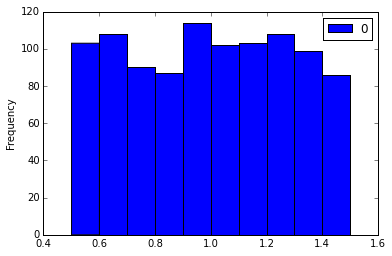

In [742]:
def ys_generator(num_samples):
    """Yield a large number of initial y points for sanity check"""
    
    for _ in range(num_samples):
        state = next(data_point)
        
        yield state.y
        
        for _ in range(10-1):
            next(data_point)
            
initial_y = ys_generator(1000)

pd.DataFrame(list(initial_y)).plot(kind='hist')

### Visualization

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


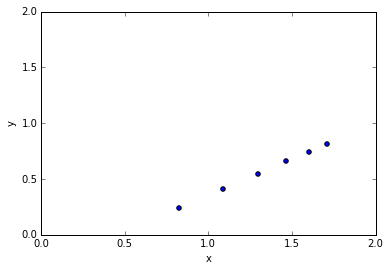

In [1]:
import math
import random

from ipywidgets import interact, fixed

time_steps = 10
decay = .8

x_start, y_start = random.uniform(0, 1), random.uniform(0, 2)

@interact(x_start=fixed(x_start), y_start=fixed(y_start), time_step=(0, time_steps), time_steps=fixed(time_steps), decay=fixed(decay))
def plot(x_start, y_start, time_step, time_steps, decay):
    x_goal, y_goal = 2, 1
    
    # Calculate initial dx and dy necessary to get the ball to the goal after time_steps
    c = (1-decay) / (1-decay**time_steps)
    dx = c * (x_goal-x_start)
    dy = c * (y_goal-y_start)
    
    # Calculate how far you've traveled from the start at each time_step
    decays = [decay**pow for pow in range(time_step)]
    x_deltas = np.append([0], np.cumsum(dx*np.array(decays)))
    y_deltas = np.append([0], np.cumsum(dy*np.array(decays)))
    
    x_positions = x_start + x_deltas
    y_positions = y_start + y_deltas
    
    axes = pd.DataFrame({'x': x_positions,
                         'y': y_positions}).plot(kind='scatter', x='x', y='y')
    
    axes.set_xlim(0, 2)
    axes.set_ylim(0, 2)